In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pickle
import itertools
import requests
import re
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from IPython.display import display, HTML, Markdown
from lightgbm import LGBMClassifier
from matplotlib.ticker import FuncFormatter
from keras.callbacks import Callback
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Bidirectional, \
    GlobalAveragePooling1D, GlobalMaxPooling1D, CuDNNGRU, CuDNNLSTM, GRU, LSTM
from keras.models import Model
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from scikitplot.metrics import plot_confusion_matrix as pcm
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
display(HTML("<style>.container { width:60% !important; }</style>"))
pd.set_option('max_colwidth', 400)

Using TensorFlow backend.


# <center>Clinical Notes Classification</center>

### <center>An Example of Natural Language Processing and Machine Learning for Healthcare</center>

# Text Classification

* ## Text classification (a.k.a. text categorization or text tagging) is the task of assigning a set of predefined categories to free-text. 


### Input: “The user interface is quite straightforward and easy to use.”

<img src="https://monkeylearn.com/static/img/text-classification-what-it-is2.png" style=" width: 1000px" align="left" />


* ## Manual classification
* ## Automatic classification
  * ### Rule-based systems
  * ### Machine Learning based systems
  * ### Hybrid systems

In [ ]:
Rule-based systems: store and manipulate knowledge to interpret information in a useful way, here to classify text

<img src="https://www.mathworks.com/content/mathworks/www/en/discovery/machine-learning/jcr:content/mainParsys3/discoverysubsection_1965078453/mainParsys/image_2128876021_cop.adapt.full.low.svg/1548225282064.svg" style=" width: 1000px" align="left" />

In [ ]:
a subfield of computer science and artificial intelligence which deals with building systems that can learn from data, instead of explicitly programmed instructions.

<center><h2>Train Model</h2></center>
<div class="container">
<img src="https://monkeylearn.com/static/img/text-classification-training.png" style=" width: 1200px" align="left" title="Train Model"/>
</div>
<br/>
<center><h2>Use Model to Predict</h2></center>
<div class="container">
<img src="https://monkeylearn.com/static/img/text-classification-predictions2.png" style=" width: 1200px" align="left" title="Use Model to Predict" />
</div>

# Data

* ## Raw Text
* ## Classification (mentioned: multilabel, binary)
  * ### Nutrition
  * ### Cognitive
  * ### Exercise
  * ### Footwear

In [2]:
notes = pd.read_csv('data/sample.txt', sep='\t', encoding='cp1252')
notes.head()

,text,Nutrition,Cognitive,Exercise,Footwear
0,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n...",1,1,0,0
1,"GENERAL APPEARANCE: Alert and cooperative. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, ...",0,1,0,0
2,"GENERAL APPEARANCE: Well developed, and well nourished. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is no peripheral edema, cyanosis or pallor. Extremities are war...",1,0,0,1
3,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n...",1,1,1,0
4,"GENERAL APPEARANCE: Alert and cooperative. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, ...",0,1,0,0


## Percentage of Annotations

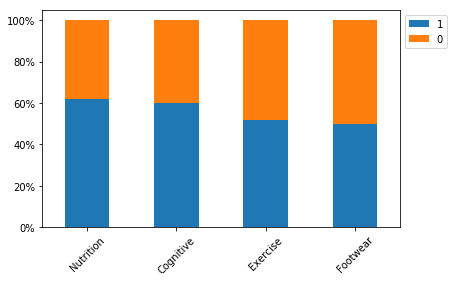

In [3]:
freq = pd.DataFrame({i: notes[i].value_counts()/notes.shape[0] for i in notes.columns.drop('text')})
fig = freq.T.plot(kind='bar', stacked=True, title='', figsize=(8,4))
box = fig.get_position()
fig.set_position([box.x0, box.y0, box.width * 0.8, box.height])
fig.legend(loc='center left', bbox_to_anchor=(1, .9))
fig.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
plt.xticks(rotation=45)
plt.show()

# Clinical Features Extraction
* ### Apache cTAKES™ is a natural language processing system for extraction of information from electronic medical record clinical free-text.
* ### cTAKES Rest Service

<img src="./ctakes_api.JPG" style=" width: 1000px" align="left"/>

# UMLS CUI 
* ## The Concept Unique Identifier for a Metathesaurus concept to which strings with the same meaning are linked.

<img src="./umls_cui.JPG" style="width: 900px" align="left"/>


In [4]:
# Helper function to retrieve cui

def get_cui(text, 
            url='https://ctakes.openshift.hlsdev.local/ctakes-web-rest/service/analyze',
            pipeline='full'):
    headers = {'Content-Type': 'text/plain'}
    data = {'analysisText': text}
    params ={'pipeline': pipeline} 
    response = requests.post(url, headers=headers, data=data, verify=False, params=params)
    cuis = ''
    for i, j in response.json().items():
        if j != {}: 
            for _, l in j.items():
                try:
                    cui = re.search('cui:\sC\d+,', l[3:][0])[0][5:-1] + ' '
                except:
                    cui = ' '
                cuis += cui 
    return cuis.strip()

In [5]:
# populate data adding cui
notes['cui'] = notes.text.apply(lambda x: get_cui(x))
notes['text_cui'] = notes.apply(lambda x: x['text'] + ' ' + x['cui'], axis=1)
notes.to_csv('notes_cui.csv',index=False)

In [2]:
notes = pd.read_csv('notes_cui.csv')
notes.head()

,text,Nutrition,Cognitive,Exercise,Footwear,cui,text_cui
0,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n...",1,1,0,0,C0017562 C0007765 C0037004 C0015392 C0015385 C0019552 C0740422 C0024109 C0040426 C0018787 C0000726 C0027342 C0021853 C0027530 C1123023 C0022417 C0302142 C0042345 C0012634 C0018808 C0043144 C0042789 C0010520 C0332516 C0231303 C0006318 C0034642 C0034929 C0239110 C0427198 C0221198 C0030232 C1642390 C0239949 C0497156 C0013604 C0035508 C0425687 C0036658 C0018021 C0231683 C0030987 C0004339,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n..."
1,"GENERAL APPEARANCE: Alert and cooperative. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, ...",0,1,0,0,C0007765 C0037004 C0015392 C0015385 C0019552 C0740422 C0024109 C0018787 C0000726 C0027342 C0021853 C1123023 C0027530 C0022417 C0302142 C0042345 C0018808 C0043144 C0042789 C0332516 C0006318 C0034642 C0034929 C0239110 C0427198 C0221198 C1642390 C0239949 C0497156 C0035508 C0013604 C0425687 C0036658 C0018021 C0231683 C0030987 C0004339,"GENERAL APPEARANCE: Alert and cooperative. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, ..."
2,"GENERAL APPEARANCE: Well developed, and well nourished. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is no peripheral edema, cyanosis or pallor. Extremities are war...",1,0,0,1,C0017562 C0007765 C0015392 C0037004 C0015385 C0019552 C0740422 C0024109 C0040426 C0018787 C0000726 C0027342 C0021853 C1123023 C0027530 C0022417 C0302142 C0042345 C0012634 C0018808 C0043144 C0042789 C0010520 C0332516 C0006318 C0034642 C0034929 C0221198 C0427198 C0030232 C1642390 C0239949 C0497156 C0013604 C0035508 C0425687 C0036658 C0018021 C0231683 C0344211 C0030987 C0004339,"GENERAL APPEARANCE: Well developed, and well nourished. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is no peripheral edema, cyanosis or pallor. Extremities are war..."
3,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n..."

In [3]:
# prepare input
X_txt = notes.text_cui
y = notes[notes.columns.drop(['text', 'cui', 'text_cui'])]

In [8]:
# Helper function to evaluate

def printmd(string):
    display(Markdown(string))

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, loc='left')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def evaluate_features(X, y, clf=None, model_prefix='BOW_'):
    
    if clf is None :
        clf = LogisticRegression()
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['SVC', 'LGBMClassifier', 'GaussianNB']:
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['KerasClassifier']:
        mclf = MultiOutputClassifier(clf)
    else:
        mclf = clf
        mclf.fit(X, y)
        
    clf_name = type(clf).__name__
    #display(Markdown('<strong>{}</strong><br/>'.format(clf_name)))
    
    if type(clf).__name__ in ['KerasClassifier']:
        pass
    else:
        pickle.dump(mclf, open('pickle/' + model_prefix + clf_name + '.pickle', 'wb'))
        
    _, ax = plt.subplots(ncols=4, figsize=(25,25))
    for j, i in enumerate(y):
        probas = cross_val_predict(clf, X, y[i], method='predict_proba')
        pred_indices = np.argmax(probas, axis=1)
        classes = np.unique(y[i])
        preds = classes[pred_indices]
        title = u'Prediction using ' + clf_name + \
            u'\nfor ' + i + ':'+ \
            u'\n\u2022 Log loss: {0:.2f}'.format(log_loss(y[i], probas)) + \
            u'\n\u2022 AUC: {0:.2f}'.format(roc_auc_score(y[i], probas[:, 1])) + \
            u'\n\u2022 Accuracy: {0:.2f}'.format(accuracy_score(y[i], preds)) + \
            u'\n\nConfusion Matrix:'
        cm = confusion_matrix(y[i], preds)
        plot_confusion_matrix(cm, classes, title=title, ax=ax[j])

# Features Transformation Models
* ## Bag of Words
* ## Latent Semantic Analysis (TF-IDF)
* ## Word Embedding (for Deep Learning)

# Other Tricks
* ## Dimension Reduction (Truncated SVD)

<img src="https://slideplayer.com/slide/5156162/16/images/16/Bag+of+Words+Example+Document+1+Term+Stopword+List+Document+2.jpg" />
<img src="https://i.stack.imgur.com/8ARA1.png" />

In [8]:
count_vectorizer = CountVectorizer(analyzer="word", tokenizer=text_to_word_sequence, stop_words='english', max_features=None, ngram_range=(1,3)) 
count_vectorizer.fit(X_txt)
X_bow = count_vectorizer.fit_transform(X_txt)
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=2018)
X_bow_trunc = svd.fit_transform(X_bow)
# save count_vectorizer
with open('pickle/count_vectorizer.pickle', 'wb') as handle:
    pickle.dump(count_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
dict(list(count_vectorizer.vocabulary_.items())[0:10])

{'general': 1375,
 'appearance': 108,
 'developed': 1132,
 'nourished': 1780,
 'alert': 87,
 'cooperative': 1055,
 'appears': 131,
 'acute': 73,
 'distress': 1162,
 'heent': 1449}

In [11]:
X_bow.shape

(50, 2394)

In [12]:
X_bow[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [6]:
y.columns

Index(['Nutrition', 'Cognitive', 'Exercise', 'Footwear'], dtype='object')

In [7]:
y.values[0]

array([1, 1, 0, 0])

# TruncatedSVD BOW
* ## Sparse Feature Matrix
* ## High Dimension (width=vocab_size)
<img src="https://www.researchgate.net/profile/Davide_Chicco/publication/275587268/figure/fig5/AS:267743941361698@1440846538624/Truncated-Singular-Value-Decomposition-Given-a-truncation-level-k-an-approximation-of.png" style="width: 1200px" align="left" />

In [15]:
svd.explained_variance_ratio_.sum()

0.9132410881092295

In [16]:
X_bow_trunc.shape

(50, 25)

In [9]:
X_bow_trunc[0]

array([ 2.17996209e+01, -4.96447122e+00, -1.44630475e+00, -1.99898299e+00,
       -2.73127114e-01, -6.00340377e-01, -1.09397153e+00, -1.10701116e+00,
       -2.12651177e+00, -1.51921897e+00, -7.49415756e-01,  2.80027709e+00,
       -1.94278866e-01,  6.99048612e-01, -3.24646347e-01,  8.52119386e-02,
        2.66745636e-01, -2.58150740e+00, -9.30999149e-01, -1.06590612e+00,
       -1.80673070e-01,  7.47775443e-01, -2.15046261e-01,  2.05262819e-02,
        1.42945641e-01])

# TF-IDF (Term Frequency — Inverse Data Frequency)
<div class="container">
<img src="https://cdn-images-1.medium.com/max/1600/1*nSqHXwOIJ2fa_EFLTh5KYw.png" style="width: 600px" align="left"/>
</div>
<div class="container">
<img src="https://cdn-images-1.medium.com/max/1600/1*q2tRgjV_J-MLvnhwNAl0KQ.png" style="width: 400px" align="left" />
</div>
<h4>Example:</h4>
<h5>Sentence A : The car is driven on the road.</h5> 
<h5>Sentence B: The truck is driven on the highway.</h5>
<br />
<div class="container">
<img src="https://cdn-images-1.medium.com/max/1500/1*q3qYevXqQOjJf6Pwdlx8Mw.png" style="width: 600px" align="left"/>
</div>

In [10]:
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=text_to_word_sequence, stop_words='english', max_features=None, ngram_range=(1,3))
tfidf_vectorizer.fit(X_txt)
X_tfidf = tfidf_vectorizer.fit_transform(X_txt)
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=2018)
X_tfidf_trunc = svd.fit_transform(X_tfidf)
# save tfidf_vectorizer
with open('pickle/tfidf_vectorizer.pickle', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL) 

In [12]:
X_tfidf.shape

(50, 2394)

In [15]:
X_tfidf[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

# Machine Learning Algorithm
* ## Logistic Regression
* ## Gaussian Naive Bayes
* ## K Nearest Neighbors
* ## Random Forest
* ## Support Vector Machines
* ## LightGBM

In [13]:
# Helper function to evaluate
def evaluate_features(X, y, clf=None, model_prefix='BOW_'):
    
    if clf is None :
        clf = LogisticRegression()
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['SVC', 'LGBMClassifier', 'GaussianNB']:
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['KerasClassifier']:
        mclf = MultiOutputClassifier(clf)
    else:
        mclf = clf
        mclf.fit(X, y)
        
    clf_name = type(clf).__name__
    #display(Markdown('<strong>{}</strong><br/>'.format(clf_name)))
    
    if type(clf).__name__ in ['KerasClassifier']:
        pass
    else:
        pickle.dump(mclf, open('pickle/' + model_prefix + clf_name + '.pickle', 'wb'))
        
    _, ax = plt.subplots(ncols=4, figsize=(25,25))
    for j, i in enumerate(y):
        probas = cross_val_predict(clf, X, y[i], method='predict_proba')
        pred_indices = np.argmax(probas, axis=1)
        classes = np.unique(y[i])
        preds = classes[pred_indices]
        title = u'Prediction using ' + clf_name + \
            u'\nfor ' + i + ':'+ \
            u'\n\u2022 Log loss: {0:.2f}'.format(log_loss(y[i], probas)) + \
            u'\n\u2022 AUC: {0:.2f}'.format(roc_auc_score(y[i], probas[:, 1])) + \
            u'\n\u2022 Accuracy: {0:.2f}'.format(accuracy_score(y[i], preds)) + \
            u'\n\nConfusion Matrix:'
        cm = confusion_matrix(y[i], preds)
        plot_confusion_matrix(cm, classes, title=title, ax=ax[j])

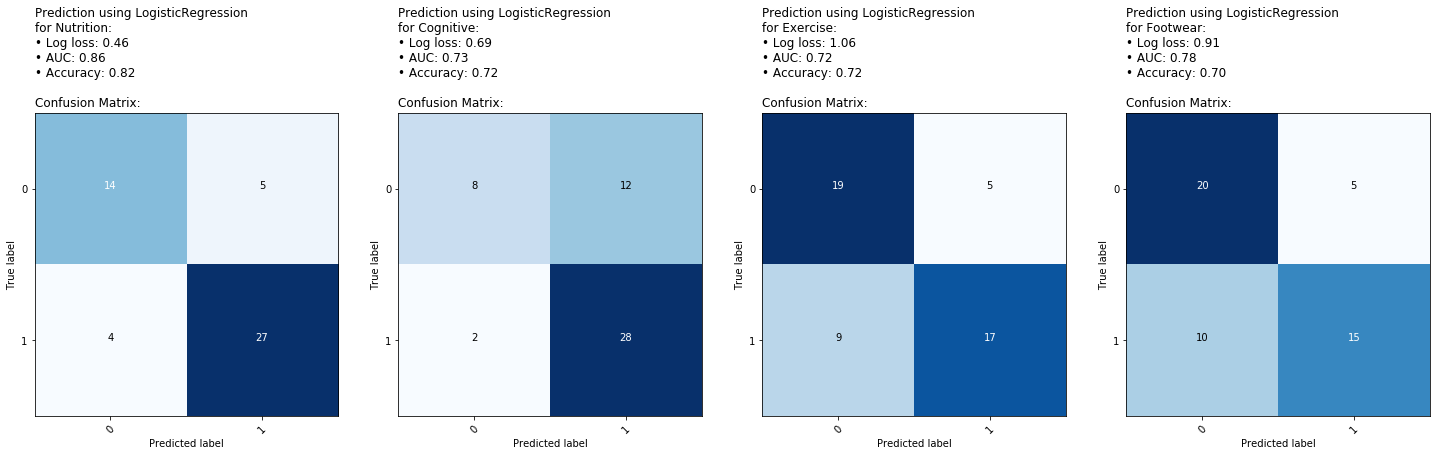

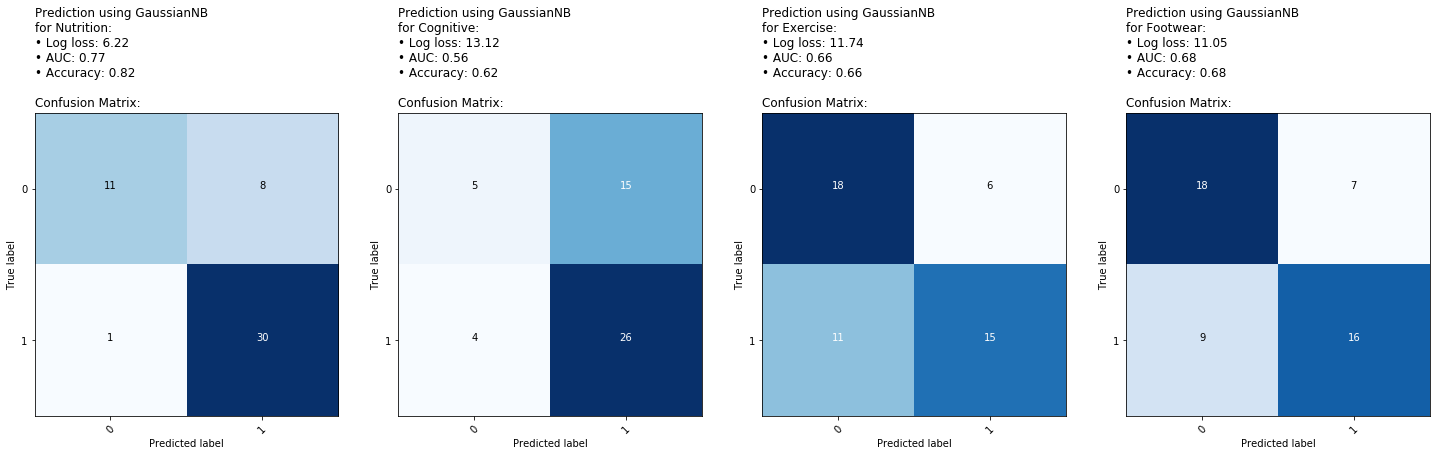

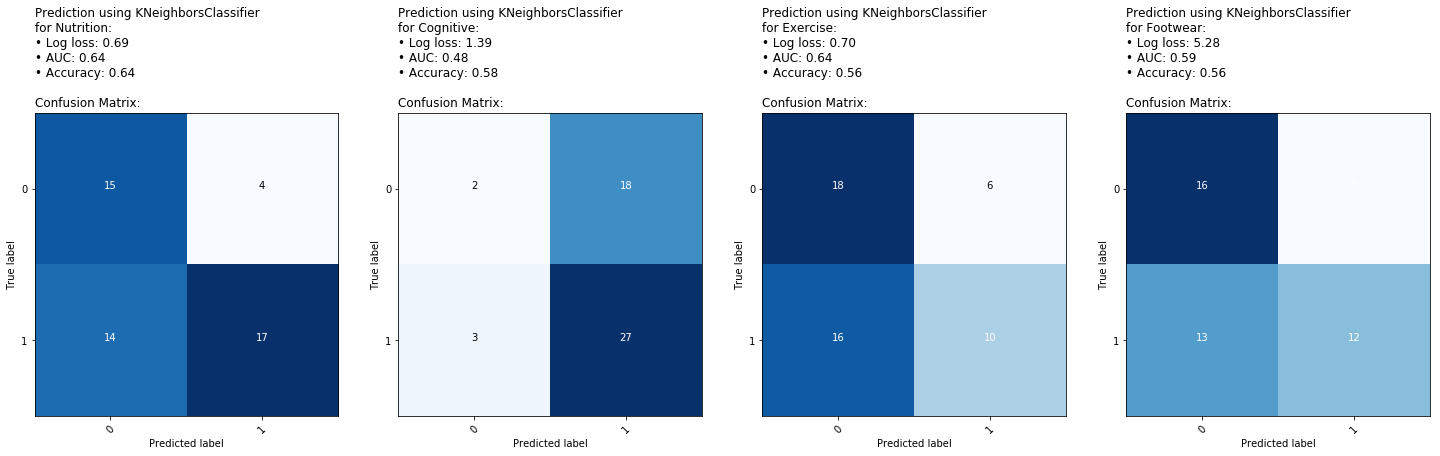

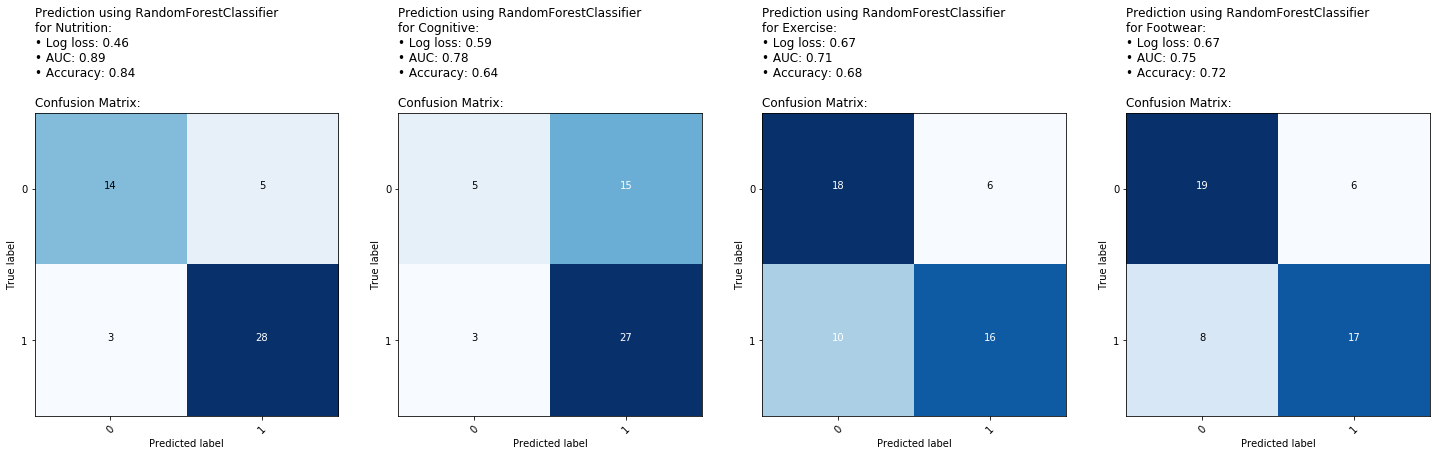

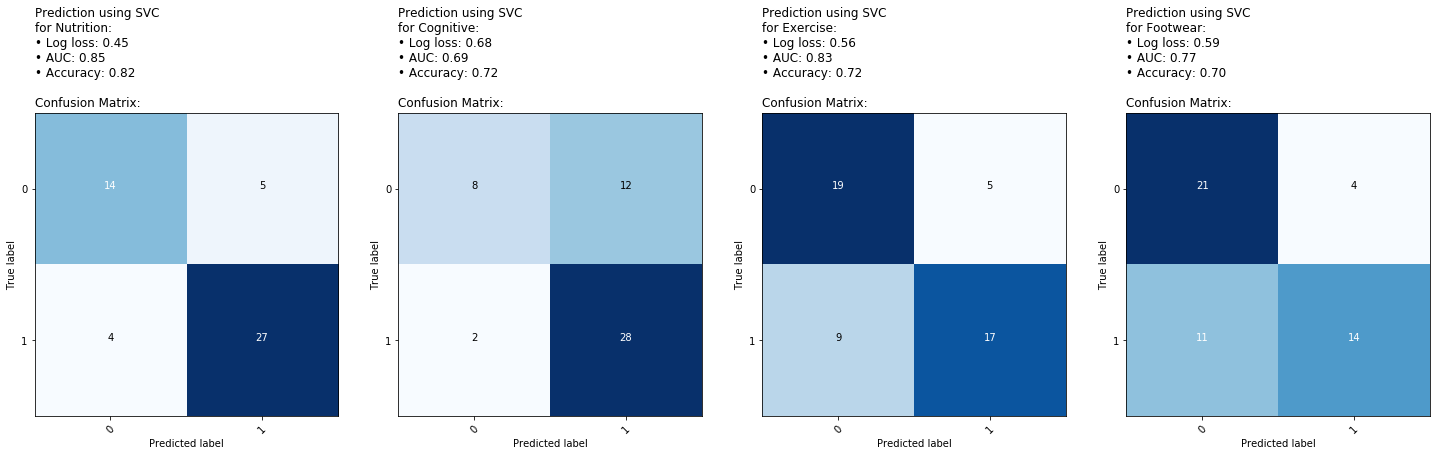

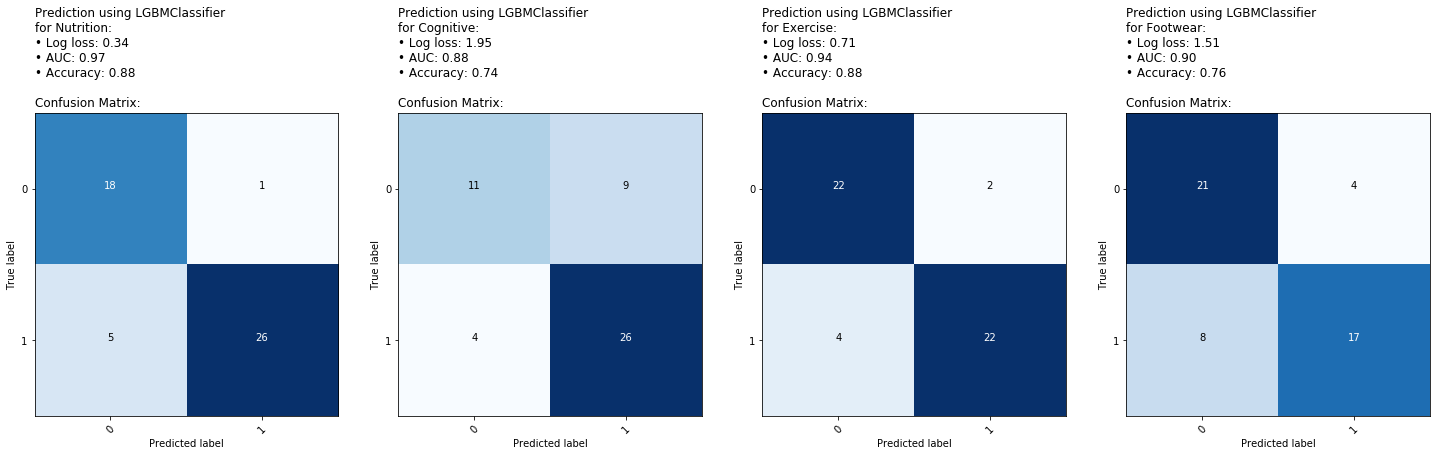

In [14]:
evaluate_features(X_bow, y)
evaluate_features(X_bow.toarray(), y, GaussianNB())
evaluate_features(X_bow, y, KNeighborsClassifier())
evaluate_features(X_bow, y, RandomForestClassifier(n_estimators=1000, max_depth=5))
evaluate_features(X_bow, y, SVC(kernel='linear', probability=True))
evaluate_features(X_bow.astype('float32'), y, LGBMClassifier(min_data=2, min_data_in_bin=2))

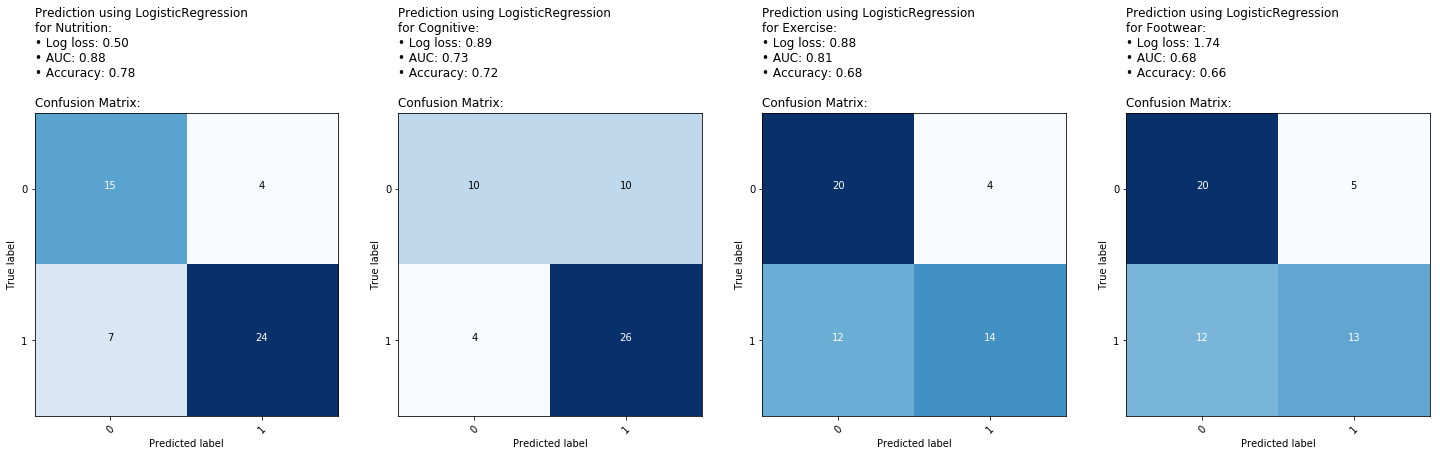

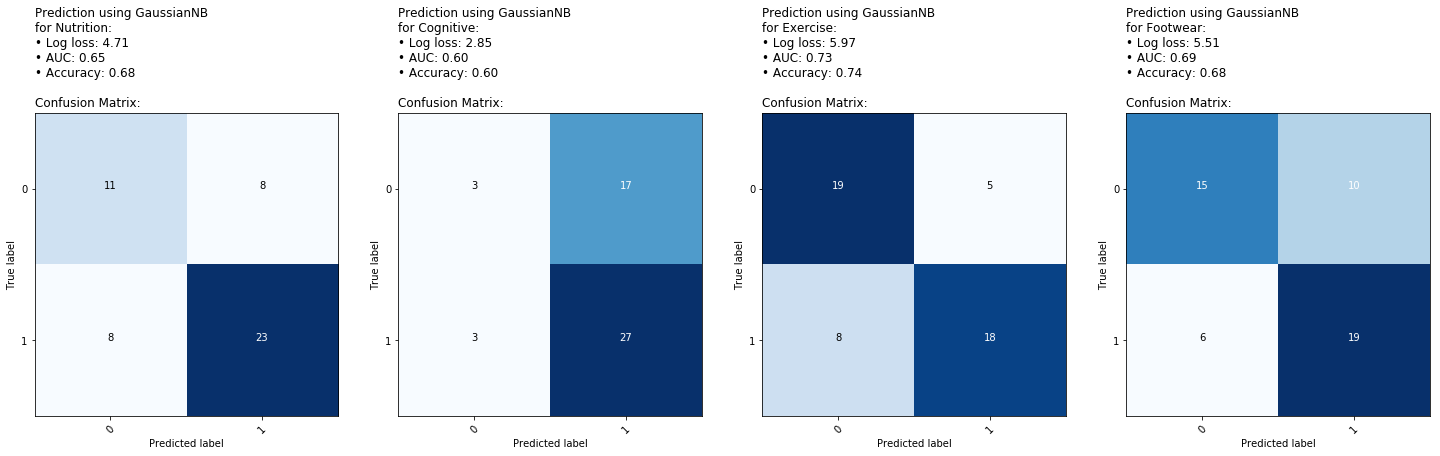

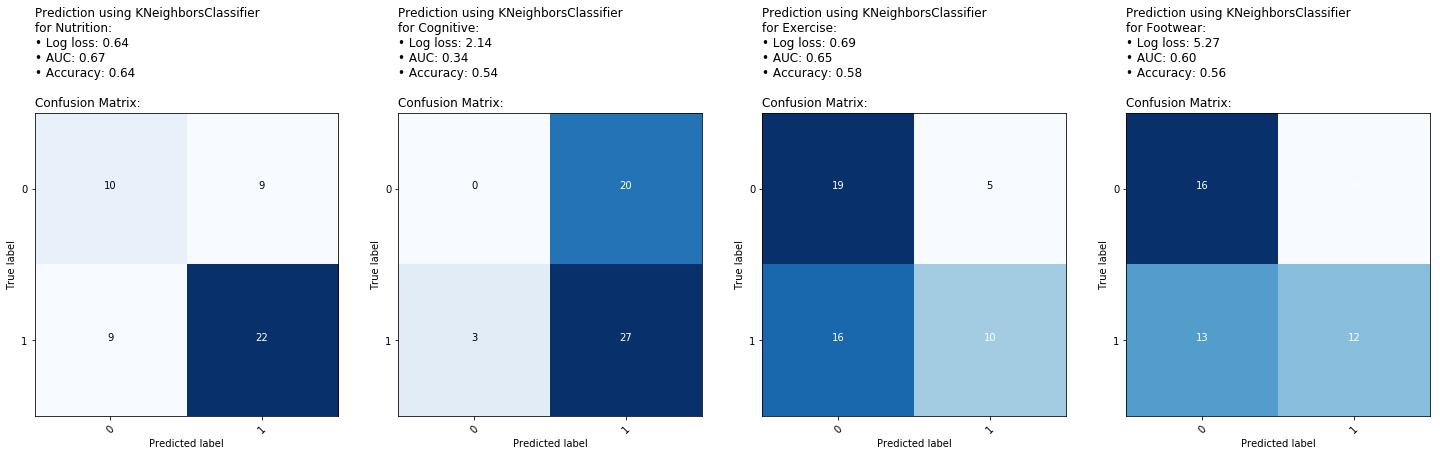

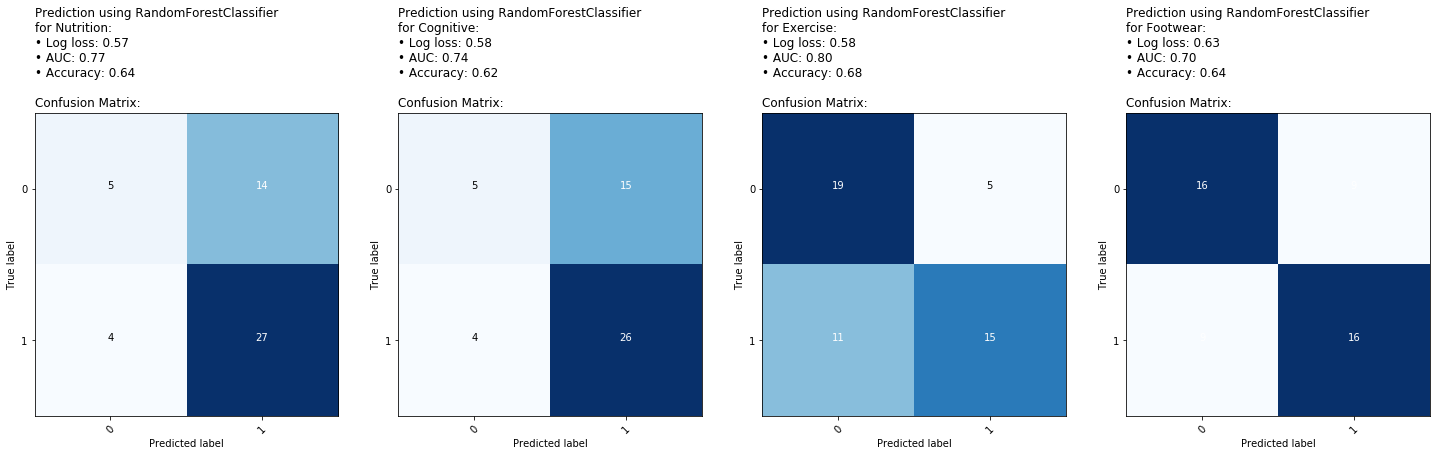

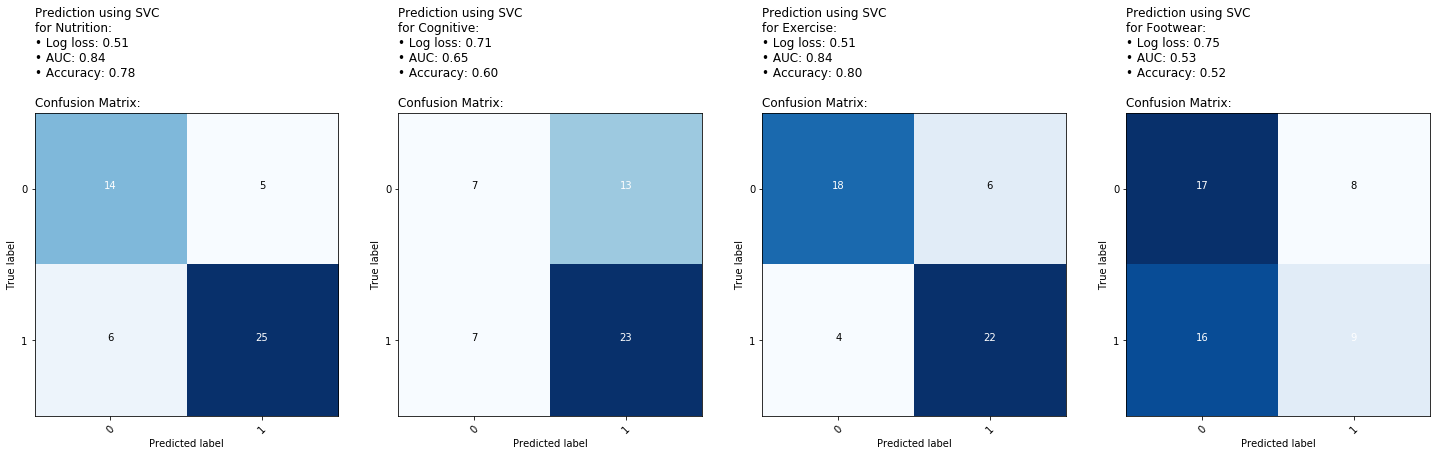

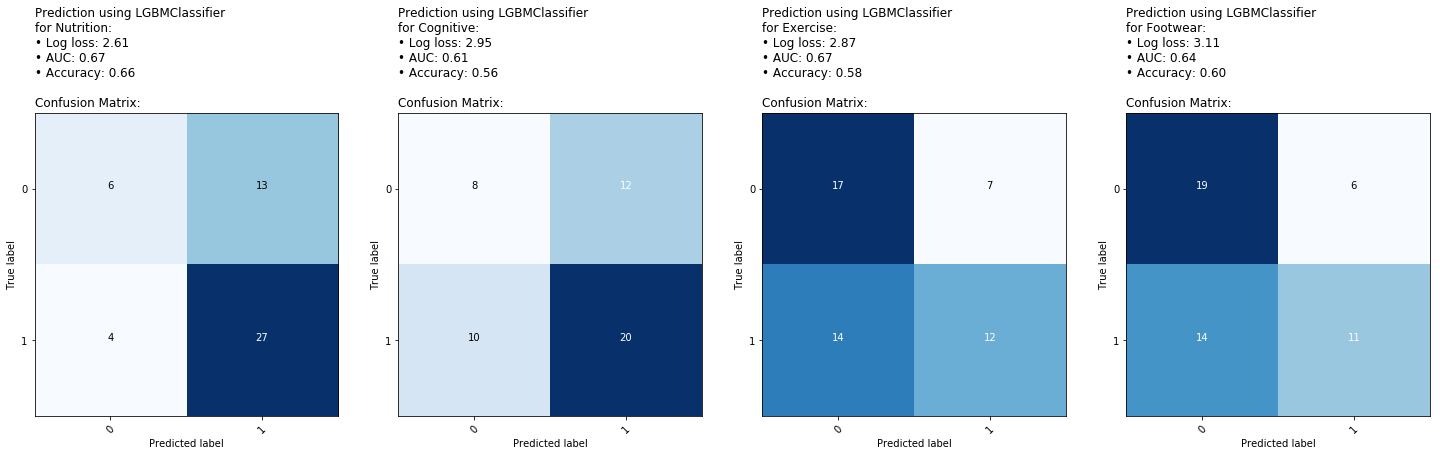

In [17]:
evaluate_features(X_bow_trunc, y, model_prefix='BOW_TRUNC_')
evaluate_features(X_bow_trunc, y, GaussianNB(), model_prefix='BOW_TRUNC_')
evaluate_features(X_bow_trunc, y, KNeighborsClassifier(), model_prefix='BOW_TRUNC_')
evaluate_features(X_bow_trunc, y, RandomForestClassifier(n_estimators=1000, max_depth=5), model_prefix='BOW_TRUNC_')
evaluate_features(X_bow_trunc, y, SVC(kernel='linear', probability=True), model_prefix='BOW_TRUNC_')
evaluate_features(X_bow_trunc, y, LGBMClassifier(min_data=2, min_data_in_bin=2), model_prefix='BOW_TRUNC_')

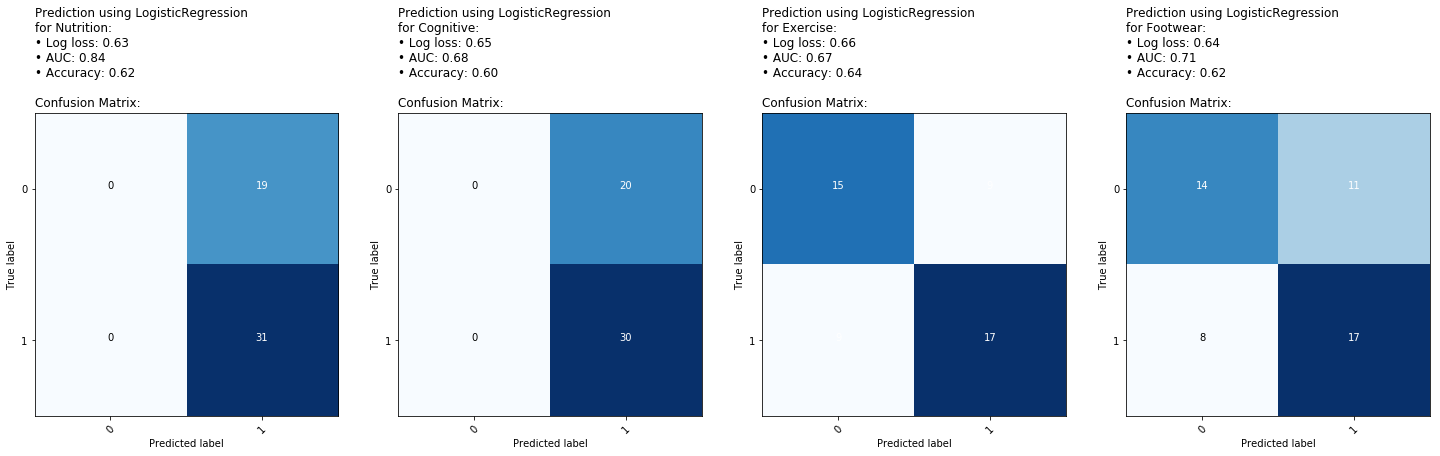

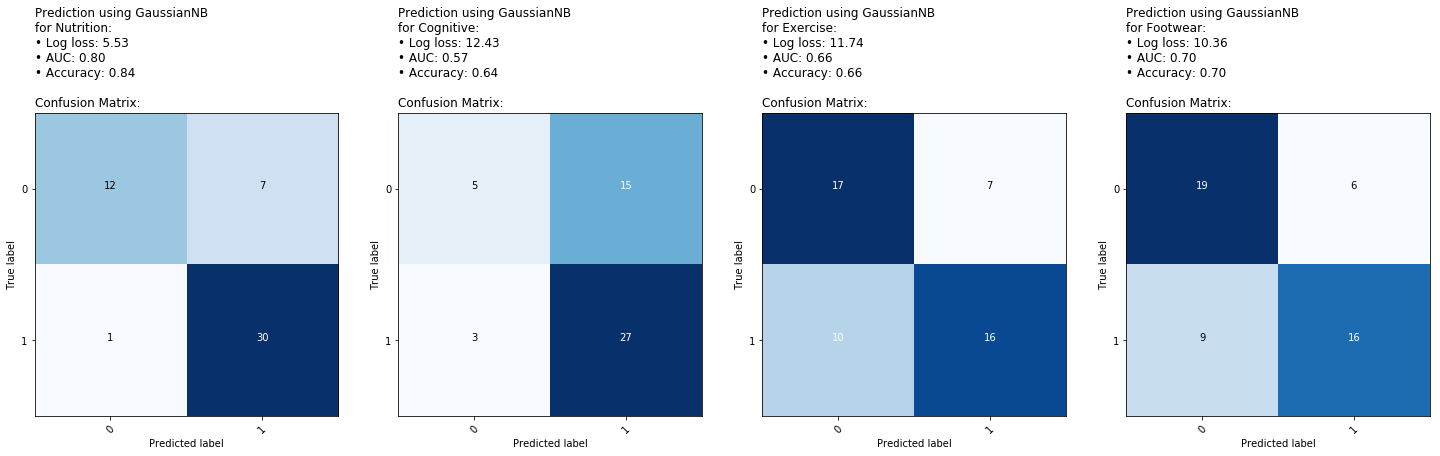

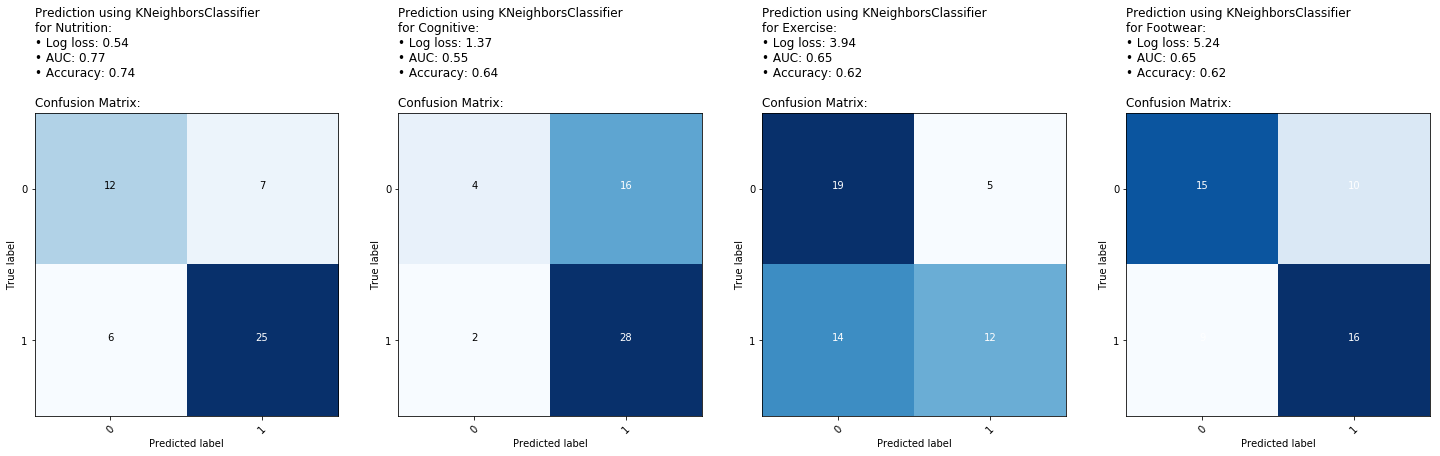

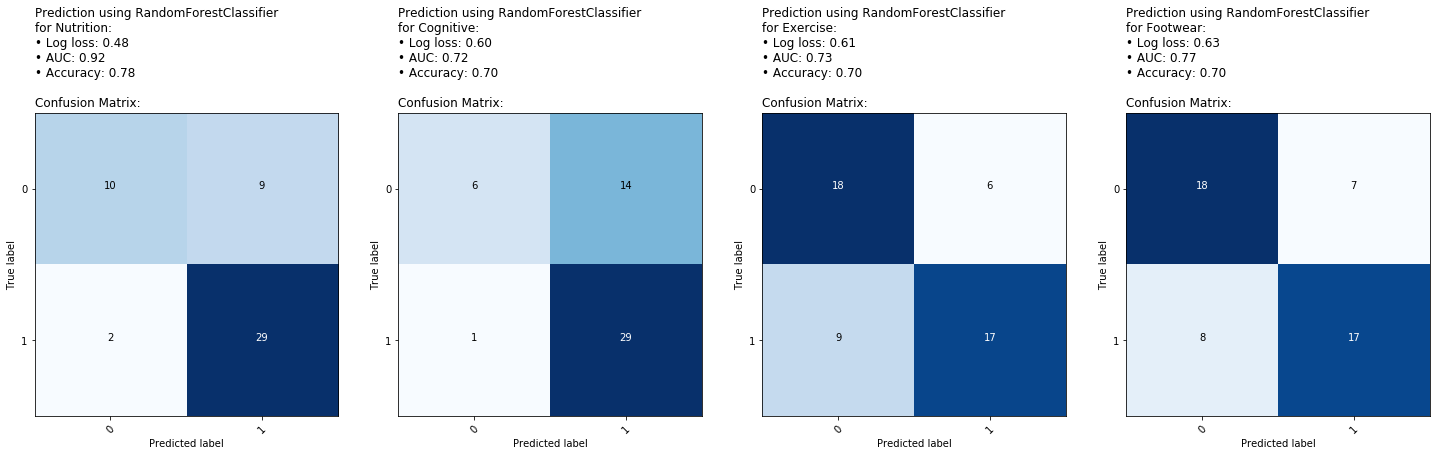

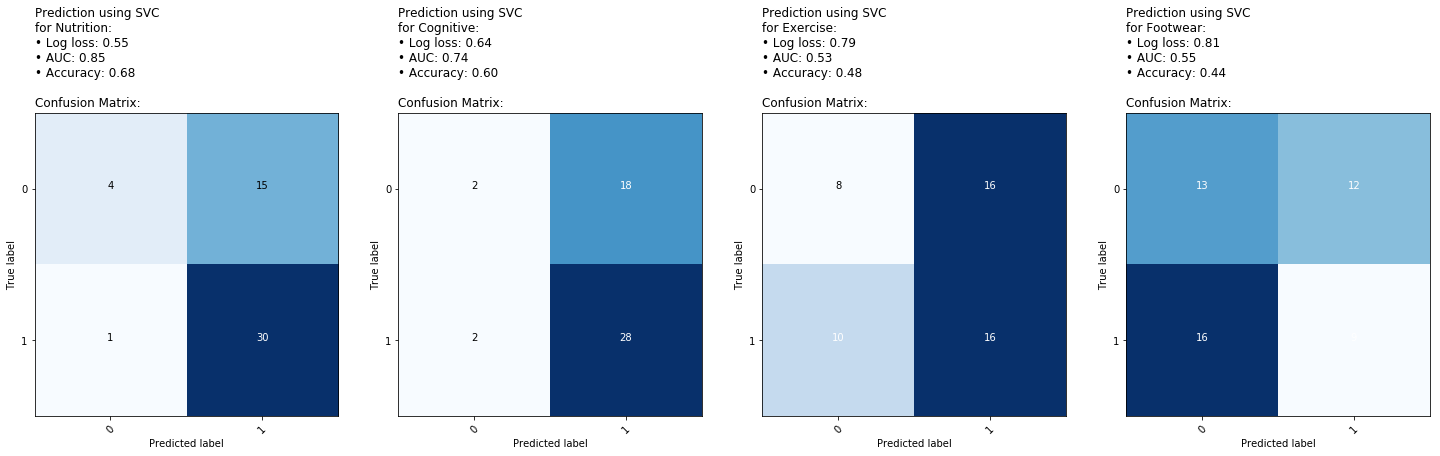

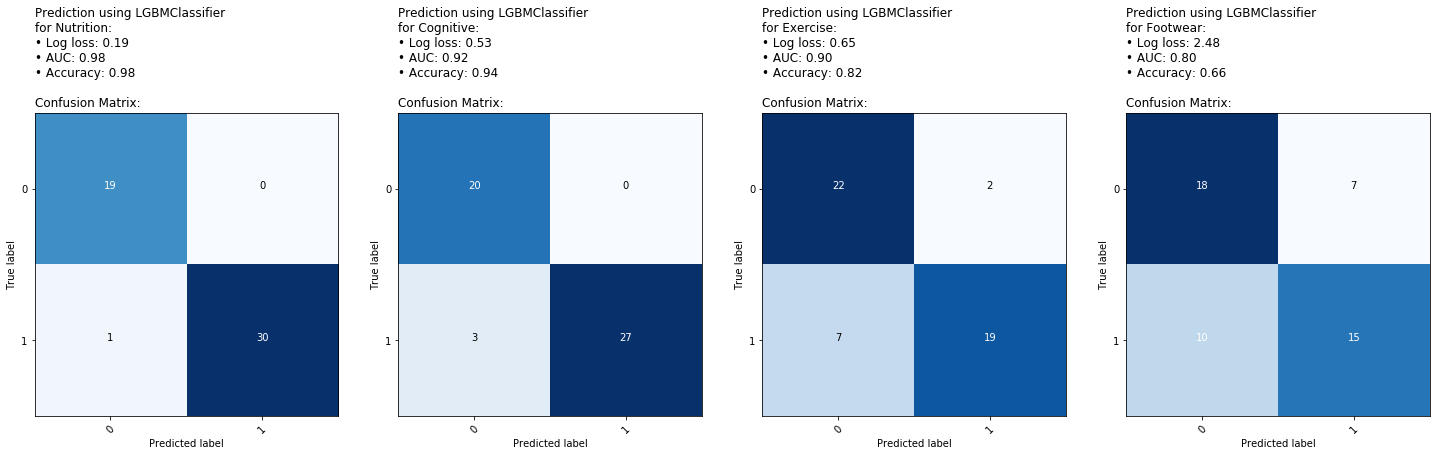

In [19]:
evaluate_features(X_tfidf, y, model_prefix='TFIDF_')
evaluate_features(X_tfidf.toarray(), y, GaussianNB(), model_prefix='TFIDF_')
evaluate_features(X_tfidf, y, KNeighborsClassifier(), model_prefix='TFIDF_')
evaluate_features(X_tfidf, y, RandomForestClassifier(n_estimators=1000, max_depth=5), model_prefix='TFIDF_')
evaluate_features(X_tfidf, y, SVC(kernel='linear', probability=True), model_prefix='TFIDF_')
evaluate_features(X_tfidf, y, LGBMClassifier(min_data=2, min_data_in_bin=2), model_prefix='TFIDF_')

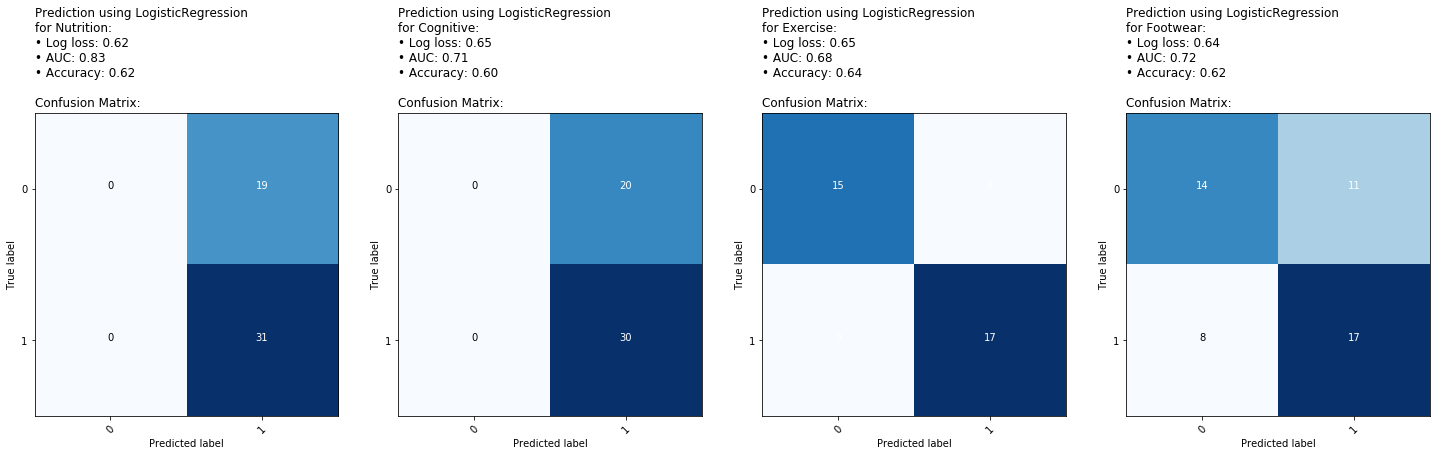

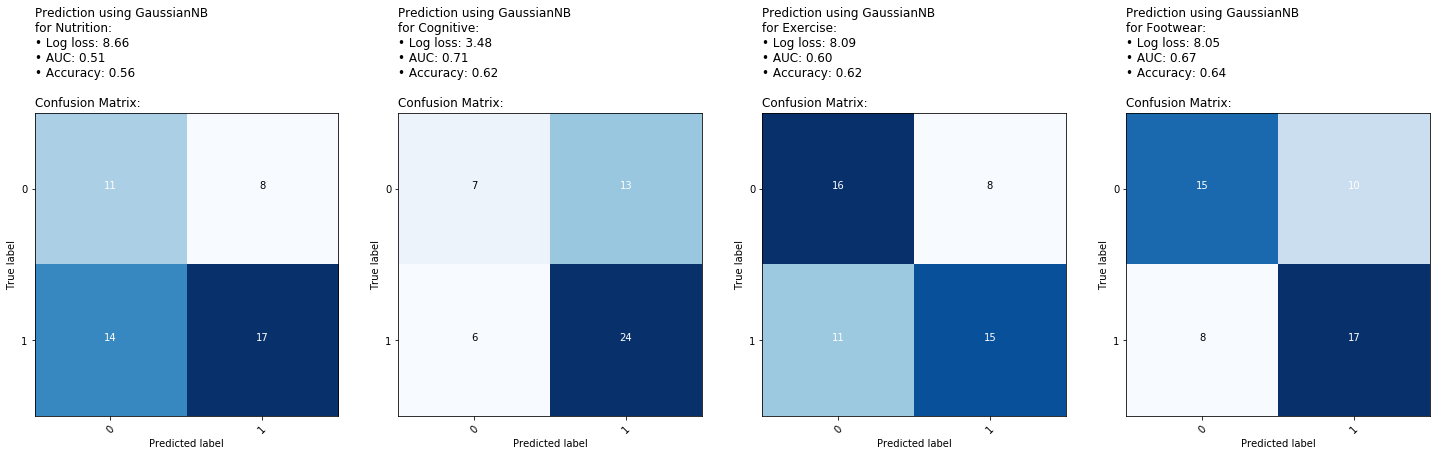

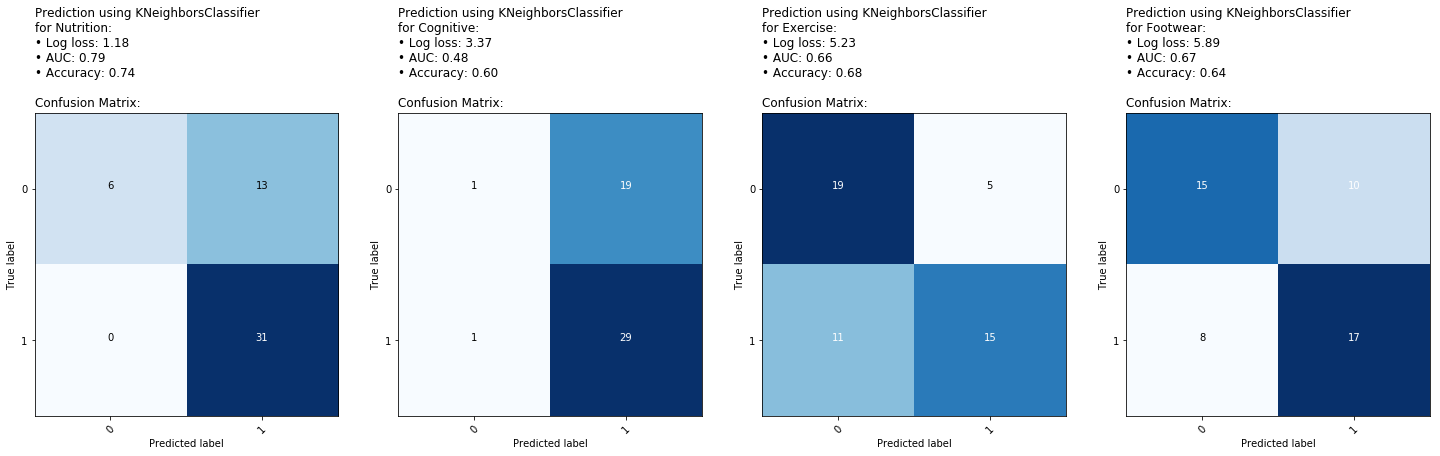

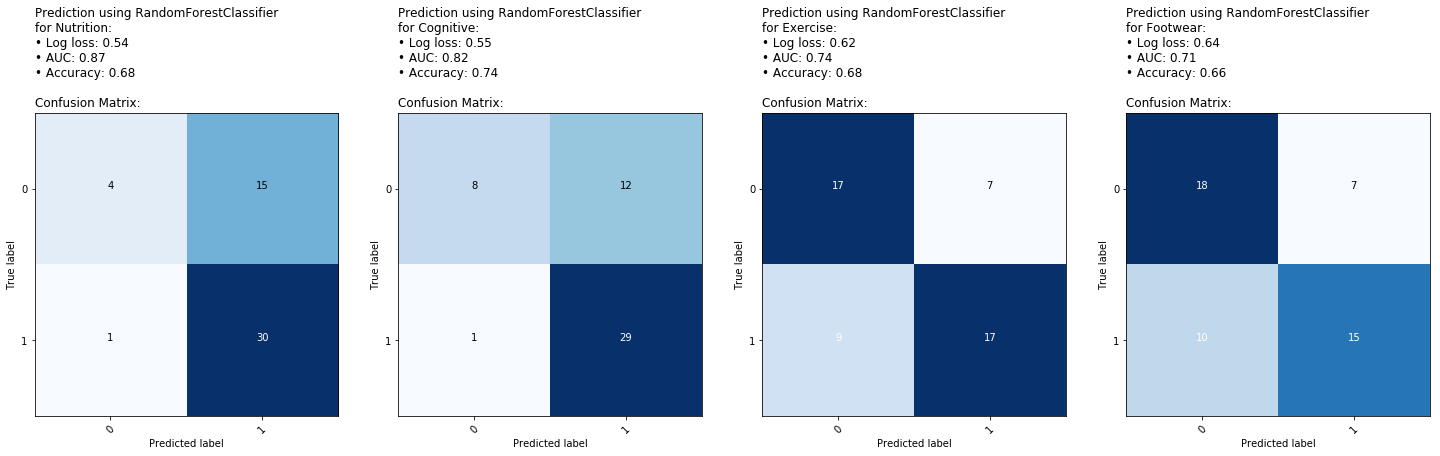

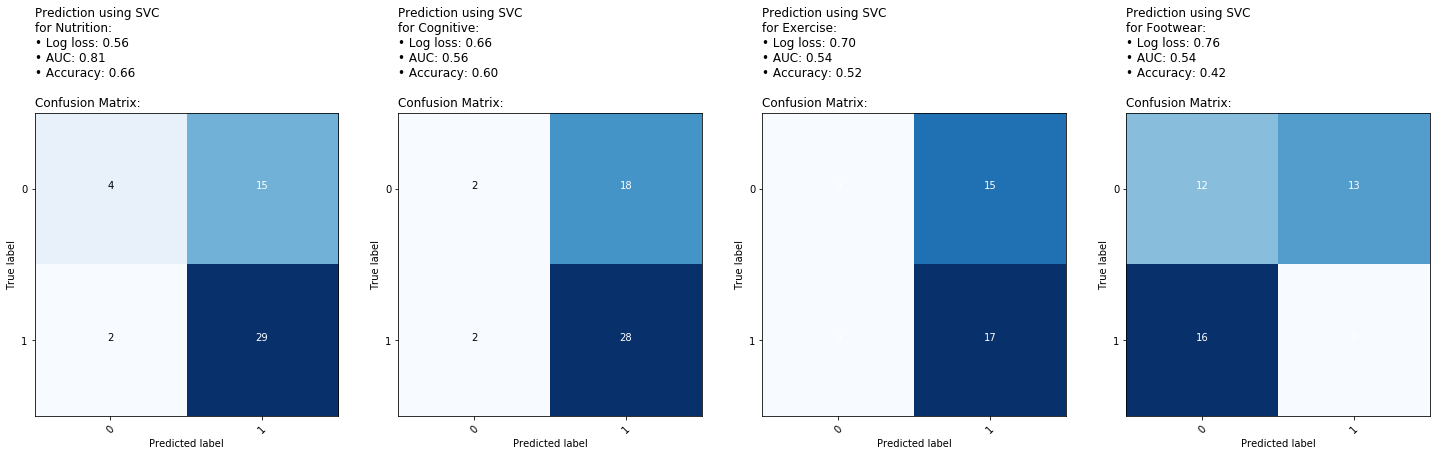

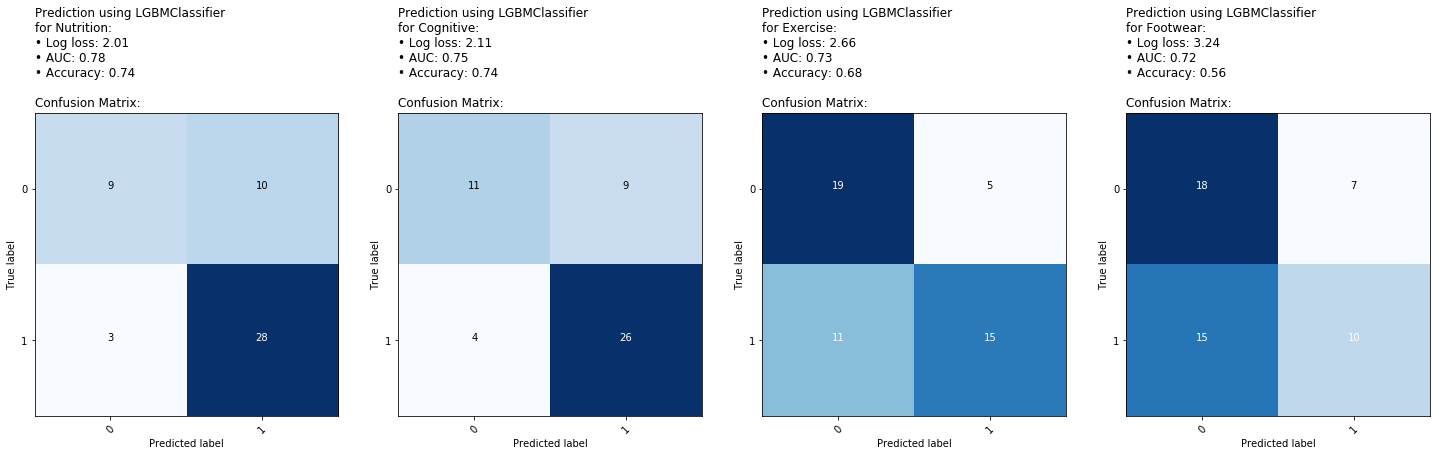

In [20]:
evaluate_features(X_tfidf_trunc, y, model_prefix='TFIDF_TRUNC_')
evaluate_features(X_tfidf_trunc, y, GaussianNB(), model_prefix='TFIDF_TRUNC_')
evaluate_features(X_tfidf_trunc, y, KNeighborsClassifier(), model_prefix='TFIDF_TRUNC_')
evaluate_features(X_tfidf_trunc, y, RandomForestClassifier(n_estimators=1000, max_depth=5), model_prefix='TFIDF_TRUNC_')
evaluate_features(X_tfidf_trunc, y, SVC(kernel='linear', probability=True), model_prefix='TFIDF_TRUNC_')
evaluate_features(X_tfidf_trunc, y, LGBMClassifier(min_data=2, min_data_in_bin=2), model_prefix='TFIDF_TRUNC_')

# Word Embedding for Deep Learning

* ## Dimensionality Reduction - it is a more efficient representation
* ## Contextual Similarity - it is a more expressive representation
* ## 3 Kinds
    * ### Word2Vec
    * ### GloVe
    * ### FastText

## Word2vec is a two-layer neural net that processes text. 
* ### Input: text corpus 
* ### output: set of vectors: each feature vector for every individual word in that corpus.
* ### emphasize on predicting neighbouring words
* ### 2 flavors

<h2>CBOW and Skip-gram</h2>
<div class="container">
<img src="./Illustration-of-the-word2vec-models-a-CBOW-b-skip-gram-16-33.png" style="width: 700px" align="left" />
</div>

In [21]:
# preprocessing 
max_features = 60000
maxlen = 1000
embed_size = 300
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_txt)
X_seq = tokenizer.texts_to_sequences(X_txt) 
X_seq = pad_sequences(X_seq, maxlen=maxlen)
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
# save tokenizer
with open('pickle/W2V_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
X_txt[3]

'GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is no peripheral edema, cyanosis or pallor. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, wheezing or diminished breath sounds. Good excursions. ABDOMEN: Positive bowel sounds, no bruits. Soft, nondistended, nontender. No guarding or rebound. No masses. EXTREMITIES: No significant deformity or joint abnormality. No edema. Peripheral pulses intact. No varicosities. Strength at shoulder/elbow/wrist/hand 5/5 bilaterally. Strength at hips/knees/ankles 5/5 bilaterally. NEUROLOGICAL: CN II-XII intact. Strength and sensation sy

In [23]:
X_seq[3][len(list(X_seq[3]))-list(X_seq[3])[::-1].index(0):]

array([ 17,  29,  10, 103,  10,  75, 104,   1, 105,   1,  70,   6,  71,
        41,   2, 101,  82,  66, 135, 136, 137, 164,   5, 149,  14, 150,
         8, 185,   1, 199,  41,  19,  17, 191,  16,  16,  50, 138,  94,
         4, 139,  13,   3, 140,   2,  51,   3,  52,  20,   5,  21,   1,
        22,   2, 151, 141,   3, 165, 106,  14,  86, 192,  14,   2,  73,
        74, 193,   3,  79,  11,  25,  95,   1,  10, 107,   2, 166,  67,
        26,  42,   6, 152,   1, 153,   4,  59,  60,  32,   3,  33,  27,
         7,  19,  61,  37, 167,  43,   7,   2,  67,  45, 168,  46,   2,
       108,   3, 109,   2,  13,  11,   2, 154, 110,   3, 155, 156,   2,
        74,  73,  39,   8,   2, 142,  15,  34, 111, 112, 113, 157,   9,
         9,  47,  15,  34, 114, 115, 116,   9,   9,  47, 117, 118, 119,
       120,   8,  15,   1,  35,  48,   1,   8,  62, 121,  83,  62, 122,
        31,   5,  18,  18,   1,  53,   5,  12,   2, 123,  58, 134, 212,
        86,  58, 186, 124, 125, 143,  30, 126, 169,  28, 187,  2

In [24]:
# helper functions
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embedding_matrix(embeddings_index, word_index, max_features, embed_size):
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i-1] = embedding_vector
    return embedding_matrix

# model function
def get_model(embedding_matrix, nb_words, model_type='GRU'):
    
    def fun():
        inp = Input(shape=(maxlen, ))
        x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
        x = SpatialDropout1D(0.4)(x)
        if model_type=='CuDNNGRU':
            x = Bidirectional(CuDNNGRU(80, return_sequences=True))(x)
        elif model_type=='GRU':
            x = Bidirectional(GRU(80, return_sequences=True))(x)
        elif model_type=='CuDNNLSTM':
            x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)
        elif model_type=='LTSM':
            x = Bidirectional(LSTM(80, return_sequences=True))(x)
        else:
            raise ValueError('Please specify model_type as one of the following:n\CuDNNGRU, CuDNNLSTM, GRU, LSTM')
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        outp = Dense(1, activation="sigmoid")(conc)

        model = Model(inputs=inp, outputs=outp)
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        return model
    
    return fun

# Pretrained Embedding Matrix

In [25]:
#prepare embedding matrix
EMBEDDING_FILE = '../toxic/data/crawl-300d-2M.vec' #word2vec
pretrained_embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf-8"))
pretrained_embedding_matrix = get_embedding_matrix(embeddings_index=pretrained_embeddings_index, word_index=word_index, max_features=max_features, embed_size=embed_size)

In [26]:
pretrained_embeddings_index['diabetes']

array([ 5.300e-02,  1.425e-01,  2.356e-01,  3.250e-02,  1.524e-01,
       -5.285e-01, -6.986e-01,  2.940e-01, -1.846e-01,  2.978e-01,
       -4.154e-01,  5.373e-01, -9.230e-02, -8.650e-02,  7.130e-01,
       -2.158e-01,  2.450e-02,  4.117e-01,  3.225e-01,  1.768e-01,
        2.857e-01,  4.545e-01,  3.074e-01,  0.000e+00,  2.206e-01,
        3.640e-02, -1.090e-01, -5.035e-01,  2.112e-01,  2.529e-01,
       -1.290e-01,  4.502e-01,  1.751e-01, -2.473e-01, -2.301e-01,
        9.140e-02,  1.990e-02, -2.478e-01,  2.615e-01,  1.470e-02,
       -2.760e-02,  2.488e-01, -3.096e-01,  1.380e-02,  6.531e-01,
        4.195e-01, -1.694e-01, -2.369e-01,  2.680e-02,  1.500e-03,
       -5.027e-01, -1.930e-01,  8.134e-01,  1.928e-01, -1.722e-01,
        6.280e-02,  3.229e-01,  4.060e-02,  1.645e-01, -1.127e-01,
       -2.610e-02, -1.232e-01,  7.720e-02, -2.452e-01, -2.149e-01,
       -1.474e-01,  2.956e-01, -2.539e-01, -2.238e-01,  9.540e-02,
        1.480e-02, -1.058e-01, -3.460e-01,  1.490e-01, -1.605e

# Artificial Neural Network
<br />
<div class="container">
<img src="https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras+Python+Tutorial/content_content_neuron.png" style="width: 800px" align="left" />
</div>
<br />
<div class="container">
<img src="https://www.kdnuggets.com/wp-content/uploads/activation.png" style="width: 800px" align="left" />
</div>
<br />
<div class="container">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/1200px-Colored_neural_network.svg.png" style="width: 300px" align="left" />
</div>

# Deep Learning
<br />
<div class="container">
<img src="https://cdn-images-1.medium.com/max/2600/1*N8UXaiUKWurFLdmEhEHiWg.jpeg" style="width: 1000px" align="left" />
</div>

# LSTM (Long Short Term Memory networks)
<br />
<div class="container">
<img src="https://cdn-images-1.medium.com/max/1000/0*mRHhGAbsKaJPbT21.png" style="width: 400px" align="left" />
</div>
<br />
<div class="container">
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" style="width: 600px" align="left" />
</div>
<br />
<div class="container">
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" style="width: 600px" align="left" />
</div>

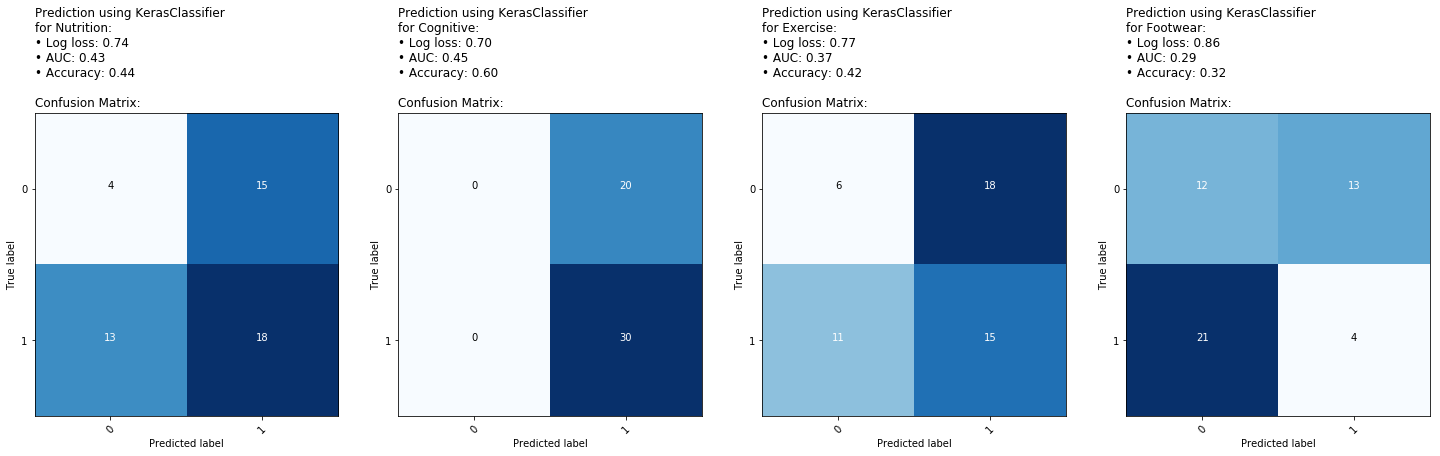

In [27]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
pre_emb_model = get_model(embedding_matrix=pretrained_embedding_matrix, nb_words=nb_words, model_type='GRU')
k_clf = KerasClassifier(build_fn=pre_emb_model, batch_size=32, epochs=2, verbose=0)
evaluate_features(X_seq, y, k_clf)

# Using Own Embedding

In [28]:
# word2vec
document = X_txt.apply(lambda x: simple_preprocess(x))
w2v_model = Word2Vec(document, iter=10, min_count=10, size=embed_size, workers=4)

In [29]:
# prepare embedding matrix
own_embeddings_index = dict(zip(w2v_model.wv.index2word, w2v_model.wv.vectors))
own_embedding_matrix = get_embedding_matrix(embeddings_index=own_embeddings_index, word_index=word_index, max_features=max_features, embed_size=embed_size)

In [30]:
own_embeddings_index['diabetes']

array([-3.46699581e-02,  1.53247505e-01,  2.40235887e-02,  5.66951185e-02,
       -6.53817924e-03, -4.31551524e-02, -9.83788222e-02, -2.35586092e-02,
       -6.51443899e-02, -2.25521568e-02,  1.60244867e-01,  3.36267315e-02,
        5.60261868e-02,  6.73015267e-02,  2.88893934e-02,  1.44474413e-02,
       -1.32227466e-01, -4.41942252e-02,  9.19229761e-02, -2.29830593e-02,
       -7.17223138e-02,  3.32482485e-03,  1.86886033e-03, -2.21321248e-02,
       -2.33236682e-02,  1.07543156e-01, -3.83824967e-02, -2.14422960e-02,
       -3.60794589e-02,  1.15742348e-01,  1.30773559e-02,  3.85353677e-02,
       -3.05684959e-03,  1.07448742e-01, -3.14633586e-02, -2.07642540e-02,
        5.27348034e-02, -1.72194955e-03, -6.48082793e-02, -2.06175819e-02,
       -1.65106007e-03,  1.11183211e-01, -7.11873993e-02, -1.31956739e-02,
       -4.71093394e-02,  1.93498153e-02, -7.23828077e-02, -1.57556235e-04,
        8.42768624e-02, -8.73673558e-02,  1.23199951e-02, -1.32504612e-01,
        2.65374910e-02, -

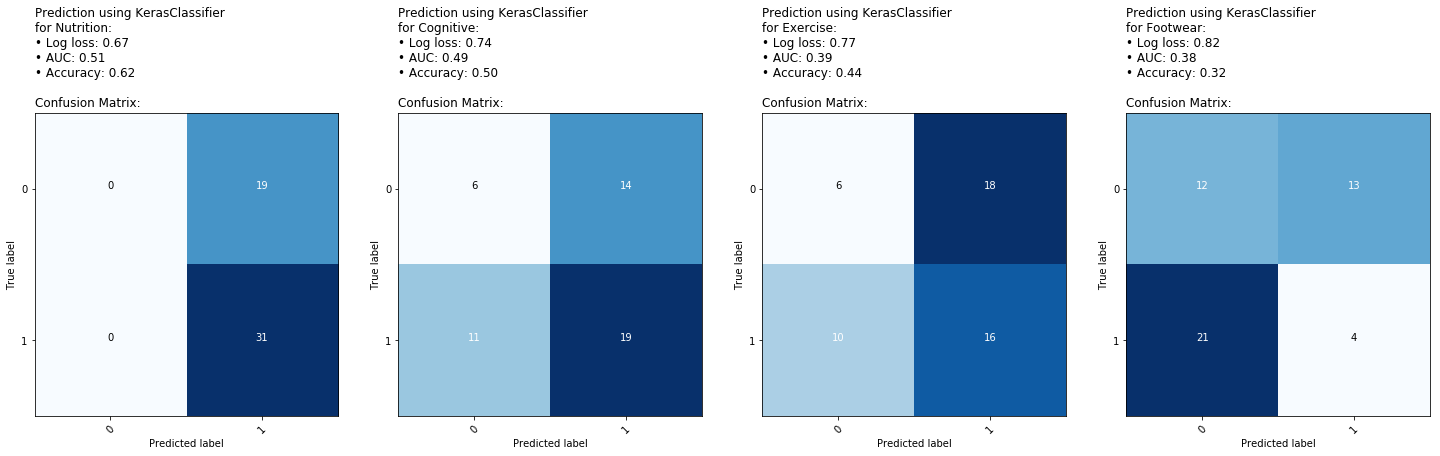

In [31]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
own_model = get_model(embedding_matrix=own_embedding_matrix, nb_words=nb_words, model_type='GRU')
k_clf = KerasClassifier(build_fn=own_model, batch_size=32, epochs=2, verbose=0)
evaluate_features(X_seq, y, k_clf)